In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-dataset/Resume/Resume.csv
/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/13998435.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/67582956.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/34349255.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/26790545.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/12674307.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11807040.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/44145704.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/27497542.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/11155153.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/17555081.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/41506705.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/54201930.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/24583187.pdf
/kaggle/input/resume-dataset/data/data/DESIGNER/38565119.pdf
/kaggle/input/resume-dataset/data/data

# Cell 1: Import Necessary Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Download stopwords if not already available
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cell 2: Load and Inspect Data

In [16]:
# Load the dataset
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

# Display the first five rows
df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Values

In [17]:
# Check for missing values
df.isnull().sum()


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

# Cell 4: Data Cleaning Function

In [18]:
import re
import spacy

# Load spaCy English model (ensure it's installed: !python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5. Process the text using spaCy
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        # Filter out stopwords, punctuation, numbers, and non-alphabetic tokens
        if token.is_stop or token.is_punct or token.like_num or not token.is_alpha:
            continue
        
        # Use lemmatized form in lowercase
        lemma = token.lemma_.lower()
        
        # Filter out tokens that are too short
        if len(lemma) > 1:
            tokens.append(lemma)
    
    # 6. Optionally, additional filtering can be applied here (e.g., parts-of-speech filtering)
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Apply the advanced cleaning function to your resume column (adjust the column name if needed)
df['cleaned_resume'] = df['Resume_str'].apply(clean_text)

# Now, you would use your vectorizer (e.g., CountVectorizer with n-grams) on 'cleaned_resume'
# For example:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=7000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['cleaned_resume'])

# And prepare your target variable (assuming 'Category' contains your labels)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])


# Cell 5: Convert Category to Numeric Labels

In [19]:
# Encode category labels into numbers
df['category_label'] = df['Category'].astype('category').cat.codes

# Display the mapping of labels
category_mapping = dict(enumerate(df['Category'].astype('category').cat.categories))
print(category_mapping)


{0: 'ACCOUNTANT', 1: 'ADVOCATE', 2: 'AGRICULTURE', 3: 'APPAREL', 4: 'ARTS', 5: 'AUTOMOBILE', 6: 'AVIATION', 7: 'BANKING', 8: 'BPO', 9: 'BUSINESS-DEVELOPMENT', 10: 'CHEF', 11: 'CONSTRUCTION', 12: 'CONSULTANT', 13: 'DESIGNER', 14: 'DIGITAL-MEDIA', 15: 'ENGINEERING', 16: 'FINANCE', 17: 'FITNESS', 18: 'HEALTHCARE', 19: 'HR', 20: 'INFORMATION-TECHNOLOGY', 21: 'PUBLIC-RELATIONS', 22: 'SALES', 23: 'TEACHER'}


# Cell 6: Train-Test Split

In [21]:
# Cell 6: Train-Test Split
# Split data into training and testing sets using the correct column name 'cleaned_resume'
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_resume'], df['category_label'], test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1987, Testing samples: 497


# Cell 7: Convert Text Data to TF-IDF Vectors

In [22]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Display the shape of the feature matrix
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")


TF-IDF feature matrix shape: (1987, 5000)


# Cell 8: Train Random Forest Model

In [23]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test_tfidf)


# Cell 9: Evaluate Model Performance

In [24]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=category_mapping.values()))


Model Accuracy: 0.6720

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.71      0.93      0.81        29
              ADVOCATE       0.81      0.70      0.75        30
           AGRICULTURE       0.00      0.00      0.00         8
               APPAREL       0.71      0.50      0.59        20
                  ARTS       0.29      0.11      0.16        18
            AUTOMOBILE       0.00      0.00      0.00         6
              AVIATION       0.82      0.86      0.84        21
               BANKING       0.63      0.74      0.68        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.72      0.48      0.58        27
                  CHEF       0.86      0.79      0.83        24
          CONSTRUCTION       0.91      0.88      0.90        34
            CONSULTANT       0.60      0.30      0.40        20
              DESIGNER       0.74      0.89      0.81  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Cell 10: Plot Confusion Matrix

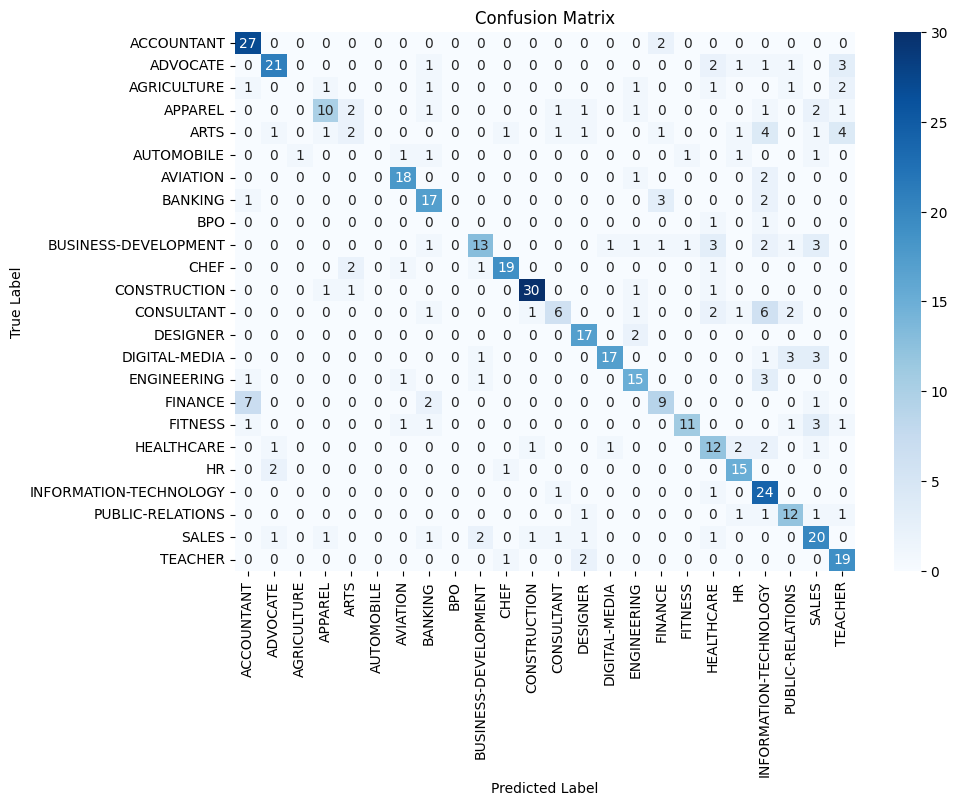

In [25]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Cell 11: Calculate Precision, Recall, and F1 Score

In [26]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")


Evaluation Metrics:
Accuracy  : 0.6720
Precision : 0.6632
Recall    : 0.6720
F1 Score  : 0.6527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
